> This is a rework of my task during Computer Vision class in 2022.

> Goal(s):
- to demonstrate harris corner detection algorithm.

# Import Library

In [1]:
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt

from scipy import ndimage

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Image Preparation

In [3]:
url = 'https://images.rawpixel.com/image_800/czNmcy1wcml2YXRlL3Jhd3BpeGVsX2ltYWdlcy93ZWJzaXRlX2NvbnRlbnQvbHIvcHgxMTk1NjU3LWltYWdlLWt3eXF6bGdvLmpwZw.jpg'

In [4]:
def generate_img(url):
  req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
  img_data = urllib.request.urlopen(req).read()
  img_array = np.frombuffer(img_data, np.uint8)
  img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
  return img

In [5]:
def show_img(img, title, cmap=None):
  plt.imshow(img, cmap=cmap)
  plt.title(title)
  plt.axis('off')

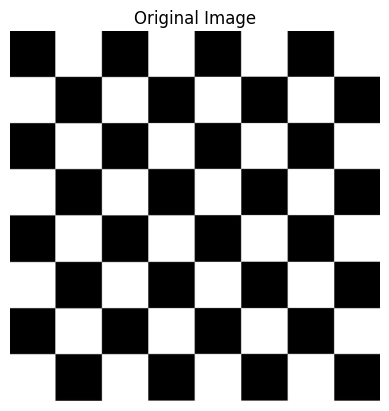

In [6]:
img = cv2.cvtColor(generate_img(url), cv2.COLOR_BGR2GRAY)
show_img(img, 'Original Image', 'gray')

# Apply Gaussian Filter

> Gaussian Filter based on this formula:

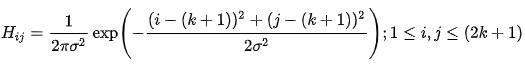

In [7]:
def gaussian_kernel(k_size, sigma):
  x, y = np.mgrid[-k_size : k_size + 1, -k_size : k_size + 1]
  g =  (1 / (2 * np.pi * (sigma ** 2))) * np.exp(-1 * ((x ** 2 + y ** 2) / (2 * (sigma ** 2))))
  return g

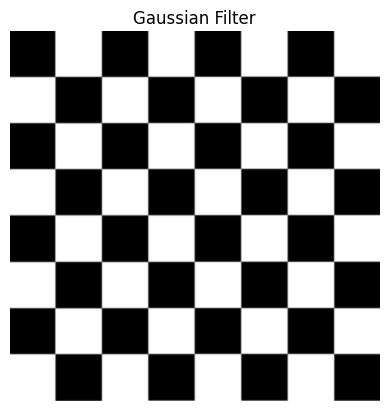

In [8]:
img_gaussian = ndimage.convolve(img, gaussian_kernel(5, 1))
show_img(img_gaussian, 'Gaussian Filter', 'gray')

# Compute the Second Moment Matrix M in a Gaussian Window

> Sobel operators based on:

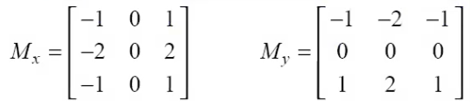

In [9]:
def sobel_filters(img):
  Mx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
  My = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], np.float32)

  Ix = ndimage.filters.convolve(img, Mx)
  Iy = ndimage.filters.convolve(img, My)
  return Ix, Iy

In [10]:
Ix, Iy = sobel_filters(img_gaussian)

> M based on this formula:

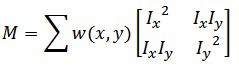

In [11]:
Ixx = Ix * Ix
Iyy = Iy * Iy
Ixy = Ix * Iy

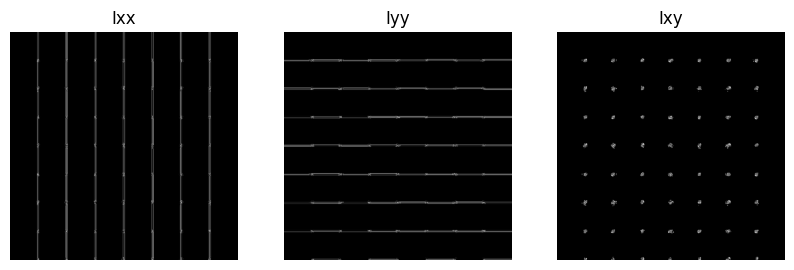

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
show_img(Ixx, 'Ixx', 'gray')
plt.subplot(1, 3, 2)
show_img(Iyy, 'Iyy', 'gray')
plt.subplot(1, 3, 3)
show_img(Ixy, 'Ixy', 'gray')

# Compute the Corner Response Function R

> R based on this formula:

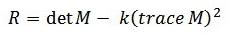

<!-- > Determinant and Trace of Matrix M based on:

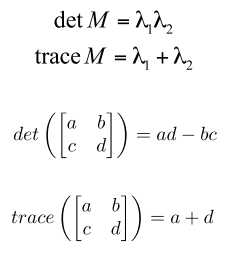 -->

In [13]:
def calc_R(img, w_size, Ixx, Iyy, Ixy, k):
  temp = int(np.floor(w_size / 2))
  img_R = np.zeros(img.shape)
  
  for x in range(temp, img.shape[0] - temp):
    for y in range(temp, img.shape[1] - temp):
      a = x - temp
      b = x + 1 + temp
      c = y - temp
      d = y + 1 + temp
      Sxx = np.sum(Ixx[a : b, c : d])
      Syy = np.sum(Iyy[a : b, c : d])
      Sxy = np.sum(Ixy[a : b, c : d])
      M = np.array([[Sxx, Sxy], [Sxy, Syy]])
      det = np.linalg.det(M) # Sxx * Syy - Sxy * Sxy
      trace = np.matrix.trace(M) # Sxx * Syy
      img_R[x - temp, y - temp] = det - (k * (trace ** 2))
  return img_R

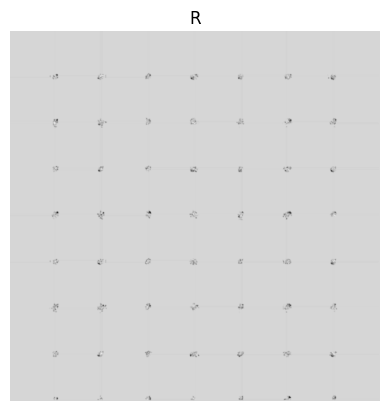

In [14]:
img_R = calc_R(img_gaussian, 3, Ixx, Iyy, Ixy, 0.05)
show_img(img_R, 'R', 'gray')

# Apply Threshold R

> Threshold based on:

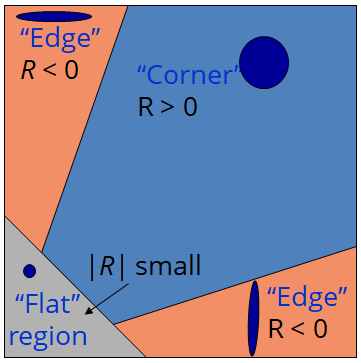

In [15]:
def thresh_R(img, w_size, thresh, img_R):
  temp = int(np.floor(w_size / 2))
  img_RThresh = np.zeros(img.shape)
  img_RThresh_res = img.copy()

  for x in range(temp, img.shape[0] - temp):
    for y in range(temp, img.shape[1] - temp):
      val = img_R[x, y]
      if val > thresh:
        img_RThresh[x, y] = val
        cv2.circle(img_RThresh_res, (y, x), 3, (255, 0, 0))

  return img_RThresh, img_RThresh_res

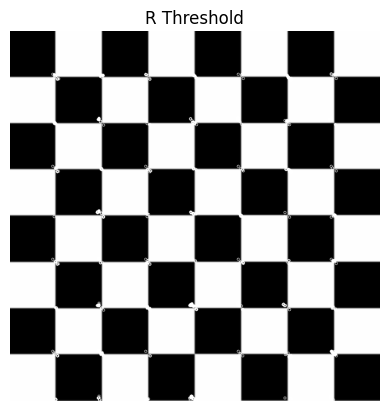

In [16]:
img_RThresh, img_RThresh_res = thresh_R(img_gaussian, 5, 0, img_R)
show_img(img_RThresh_res, 'R Threshold', 'gray')

# Apply Non-Maxima Suppression

> Non Maximum Suppression traces along the edges found (compare it to its neighbors) and suppresses any pixel value that is not at the maximum suppression in the image. Hence, it results tidier output image.

In [17]:
def non_max_suppression(img, k_size):
  temp = int(np.floor(k_size / 2))
  img_nms = img.copy()
  tx, ty = np.mgrid[-temp : temp + 1, -temp : temp + 1]

  for x in range(temp, img.shape[0] - temp):
    for y in range(temp, img.shape[1] - temp):
      init = img_nms[0][0]
      for i in range(tx.shape[0]):
        for j in range(ty.shape[1]):
          if (init < img_nms[x + tx[i][j]][y + ty[i][j]]):
            init = img_nms[x + tx[i][j]][y + ty[i][j]]
          else:
            img_nms[x + tx[i][j]][y + ty[i][j]] = 0
  return img_nms

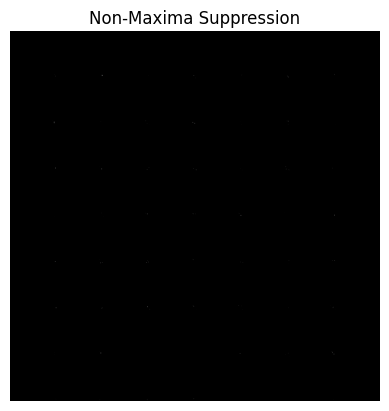

In [18]:
img_RThreshNMS = non_max_suppression(img_RThresh, 5)
show_img(img_RThreshNMS, 'Non-Maxima Suppression', 'gray')

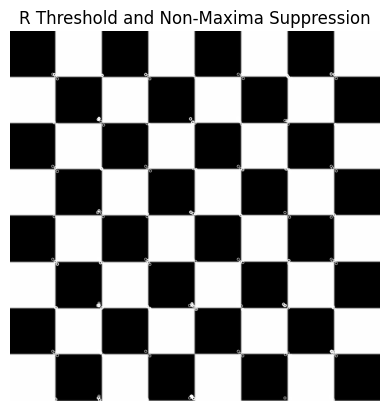

In [19]:
img_RThresh2, img_RThresh_res2 = thresh_R(img_gaussian, 5, 0, img_RThreshNMS)
show_img(img_RThresh_res2, 'R Threshold and Non-Maxima Suppression', 'gray')

# Comparation with CV2 Library

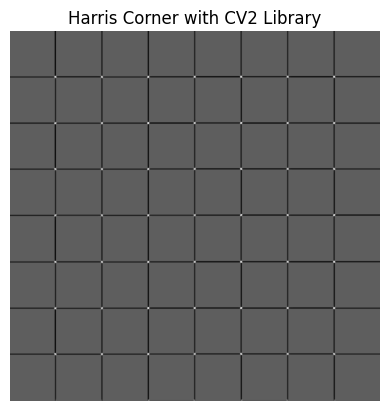

In [20]:
hc = cv2.cornerHarris(img, 3, 5, 0.05)
show_img(hc, 'Harris Corner with CV2 Library', 'gray')